In [1]:
import os
from astropy.io import ascii

import matplotlib.pyplot as plt

ZTF_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data/IRSA"

# obtained from IRSA analysis tool
ZG_QUARTER_PHASE_MAG = 17.4091840
ZR_QUARTER_PHASE_MAG = 16.6606370

In [2]:
zg = ascii.read(os.path.join(ZTF_DATA_DIR, "irsa-zg.tbl"))
zg.show_in_notebook()

idx,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
,,,d,d,mag,mag,,,deg,deg,,,,,,,mag,mag,mag,,,s,,
0,771103200012081,47448814,2458228.984821069,58228.4881481,17.5840454,0.0197342671,0,zg,339.9469627,45.1464159,0.361000001,-0.00300000003,20180420488067,771,3,2,20.3199997,26.1658897,0.0215688683,-0.0297699906,1.12665039e-05,30.0,1.80200005,1
1,771103200012081,48044724,2458234.944095733,58234.4472454,17.4334183,0.018555779,0,zg,339.9469408,45.1463974,0.931999981,-0.05999999866,20180426447199,771,3,2,19.5400009,25.6539249,0.0282153077,-0.0344086438,1.91989966e-05,30.0,2.12599993,1
2,771103200012081,48050421,2458235.001065248,58234.504213,17.4940319,0.0190106239,0,zg,339.9469111,45.1464201,0.649999976,-0.05999999866,20180426504178,771,3,2,20.0400009,26.1324596,0.0191307608,-0.0412657112,8.85321879e-06,30.0,1.51199996,1
3,771103200012081,49846564,2458252.963232793,58252.4656481,17.5891399,0.0197770167,0,zg,339.9469224,45.1464253,1.279999971,0.04199999943,20180514465637,771,3,2,21.1599998,26.2559261,0.0154842595,-0.0813824013,5.97686767e-06,30.0,1.44099998,1
4,771103200012081,50142988,2458255.9276150335,58255.4298843,17.3031044,0.0176594257,0,zg,339.9469268,45.1464214,0.59799999,-0.01799999923,20180517429873,771,3,2,21.1000004,26.2028542,0.0149421003,-0.0593302026,5.42393491e-06,30.0,1.64900005,1
5,771103200012081,50747070,2458261.9687530138,58261.470706,17.5298138,0.0192911923,0,zg,339.946875,45.1464203,1.470000029,0.00400000019,20180523470671,771,3,2,21.2000008,26.2077541,0.0167469457,-0.0233822055,6.80576795e-06,30.0,1.28400004,1
6,771103200012081,51547567,2458269.974170587,58269.4756713,17.5743046,0.0196530558,0,zg,339.9469458,45.1464186,1.210000038,-0.06700000167,20180531475637,771,3,2,19.7299995,26.2844353,0.0199463703,-0.0297663994,9.64130231e-06,30.0,1.18499994,1
7,771103200012081,51842940,2458272.928083962,58272.4294097,17.3208179,0.0177750532,0,zg,339.9469204,45.1464128,0.474999994,0.01300000027,20180603429387,771,3,2,20.6200008,26.2381649,0.015438539,-0.0462764166,5.9277836e-06,30.0,1.33700001,1
8,771103200012081,52145059,2458275.949447431,58275.4505903,17.4045334,0.0183477495,0,zg,339.9469251,45.1464547,1.199000001,-0.00999999978,20180606450579,771,3,2,20.7800007,26.3219357,0.015254084,-0.095678106,5.98213501e-06,30.0,1.21300006,1


In [3]:
zr = ascii.read(os.path.join(ZTF_DATA_DIR, "irsa-zr.tbl"))
zr.show_in_notebook()

idx,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
,,,d,d,mag,mag,,,deg,deg,,,,,,,mag,mag,mag,,,s,,
0,771203200016558,50146679,2458255.9645266226,58255.466794,16.9123917,0.0152251096,0,zr,339.9469016,45.1464621,1.29299998,-0.0149999997,20180517466782,771,3,2,20.5400009,26.2009964,0.0124264481,0.059421476,3.73802709e-06,30.0,1.38499999,1
1,771203200016558,50445651,2458258.9544024398,58258.456516,16.8072433,0.0146829495,0,zr,339.9469249,45.1464132,1.06700003,-0.0099999998,20180520456516,771,3,2,21.0599995,26.1476097,0.0119695496,0.079585649,3.55630186e-06,30.0,1.39699996,1
2,771203200016558,51238496,2458266.883285851,58266.384965,16.7090816,0.0142222922,0,zr,339.9469262,45.1463907,0.329,-0.0040000002,20180528384965,771,3,2,19.7700005,26.1124535,0.0155356405,0.07908915,5.938904e-06,30.0,1.79700005,1
3,771203200016558,51543026,2458269.9287628,58269.430266,16.6873932,0.0141260419,0,zr,339.9469277,45.1464315,1.22300005,-0.0240000002,20180531430266,771,3,2,20.2399998,26.194561,0.0118931765,0.069368958,3.41508166e-06,30.0,1.37600005,1
4,771203200016558,51846241,2458272.96109526,58272.462419,16.8001652,0.0146483108,0,zr,339.9469258,45.1464135,0.662,-0.0390000008,20180603462407,771,3,2,20.9300003,26.1832008,0.0154983643,0.08160118,6.0596708e-06,30.0,1.20099998,1
5,771203200016558,52143282,2458275.9316801345,58275.432824,16.6898041,0.0141366478,0,zr,339.9469379,45.1464164,0.98900002,-0.0500000007,20180606432812,771,3,2,20.9500008,26.1962662,0.0123049216,0.078738935,3.85735757e-06,30.0,1.28299999,1
6,771203200016558,52446762,2458278.966670489,58278.467627,16.8298531,0.0147951189,0,zr,339.9469234,45.1464052,1.45299995,-0.1190000027,20180609467616,771,3,2,21.2000008,26.19487,0.0151716312,0.084598653,5.64753782e-06,30.0,1.13800001,1
7,771203200016558,52747144,2458281.9706781623,58281.471447,16.8058014,0.0146758724,0,zr,339.9469148,45.146414,0.47999999,0.0450000018,20180612471447,771,3,2,21.2000008,26.2144279,0.0128076626,0.083170958,4.06250047e-06,30.0,1.11099994,1
8,771203200016558,53046862,2458284.968044237,58284.468623,16.7476749,0.0143984202,0,zr,339.9469344,45.1464135,0.271,0.0299999993,20180615468588,771,3,2,20.7099991,25.7165642,0.0278631896,0.080842882,1.9219804e-05,30.0,1.10000002,1


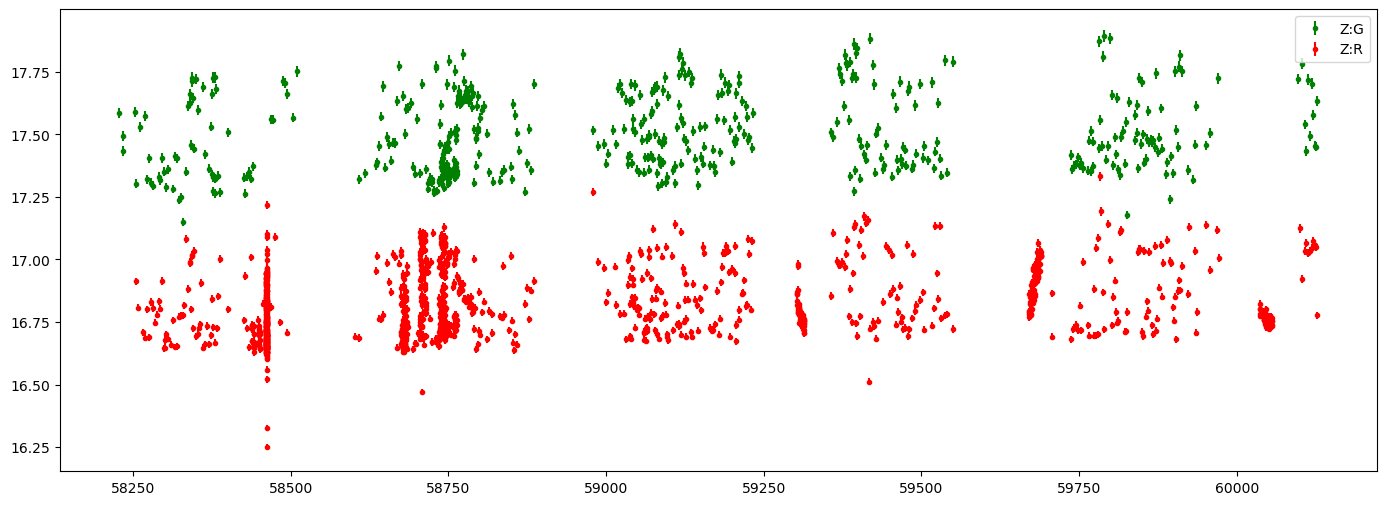

In [4]:
plt.figure(figsize=(17, 6))
plt.errorbar(zg['mjd'], zg['mag'], zg['magerr'], linestyle='none', marker='.', color='green', label='Z:G')
plt.errorbar(zr['mjd'], zr['mag'], zr['magerr'], linestyle='none', marker='.', color='red', label='Z:R')
plt.legend()

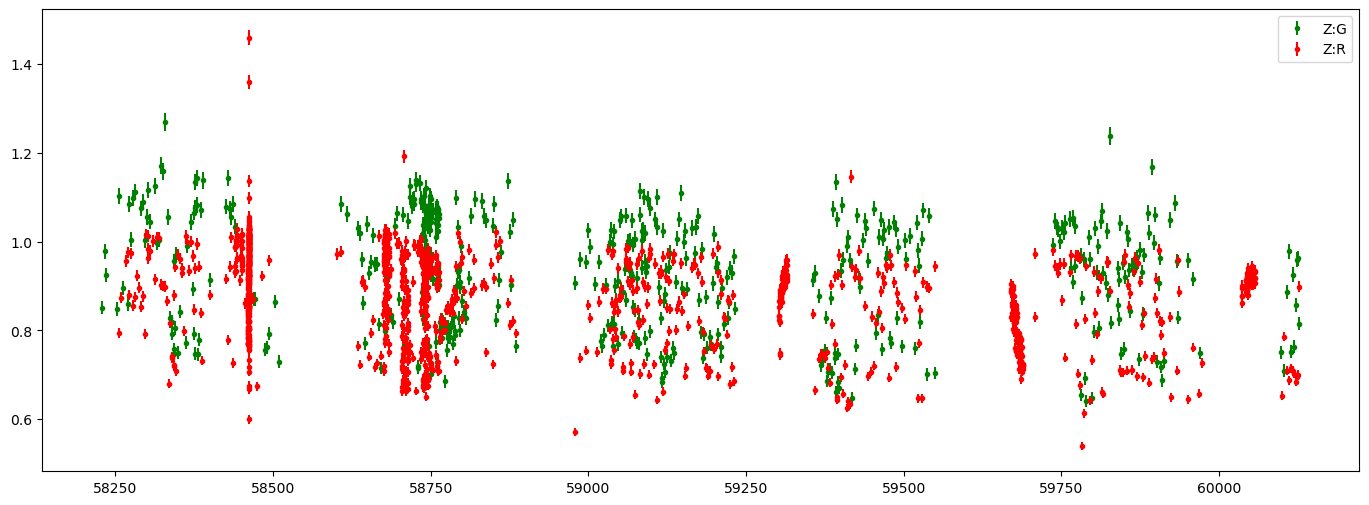

In [5]:
import math

# converting magnitudes to fluxes; since these are differential magnitudes we can convert them to fluxes using the expression outlined in this comment:
	# https://github.com/phoebe-project/phoebe2/discussions/507#discussioncomment-1135476
# failed to calculate flux error; same formula can't be used
zg['flux'] = 10**(-(2/5) * (zg['mag'].value - ZG_QUARTER_PHASE_MAG))
zr['flux'] = 10**(-(2/5) * (zr['mag'].value - ZR_QUARTER_PHASE_MAG))

# formula taken from:
# https://astronomy.stackexchange.com/questions/38371/how-can-i-calculate-the-uncertainties-in-magnitude-like-the-cds-does
	# might not be very accurate, since I haven't found the raw fluxes and am instead using normalized fluxes calculated above
zg['fluxerr'] = (zg['flux'] * zg['magerr'] * math.log(10)) / 2.5
zr['fluxerr'] = (zr['flux'] * zr['magerr'] * math.log(10)) / 2.5

plt.figure(figsize=(17, 6))
plt.errorbar(zg['mjd'], zg['flux'], zg['fluxerr'], linestyle='none', marker='.', color='green', label='Z:G')
plt.errorbar(zr['mjd'], zr['flux'], zr['fluxerr'], linestyle='none', marker='.', color='red', label='Z:R')
plt.legend()

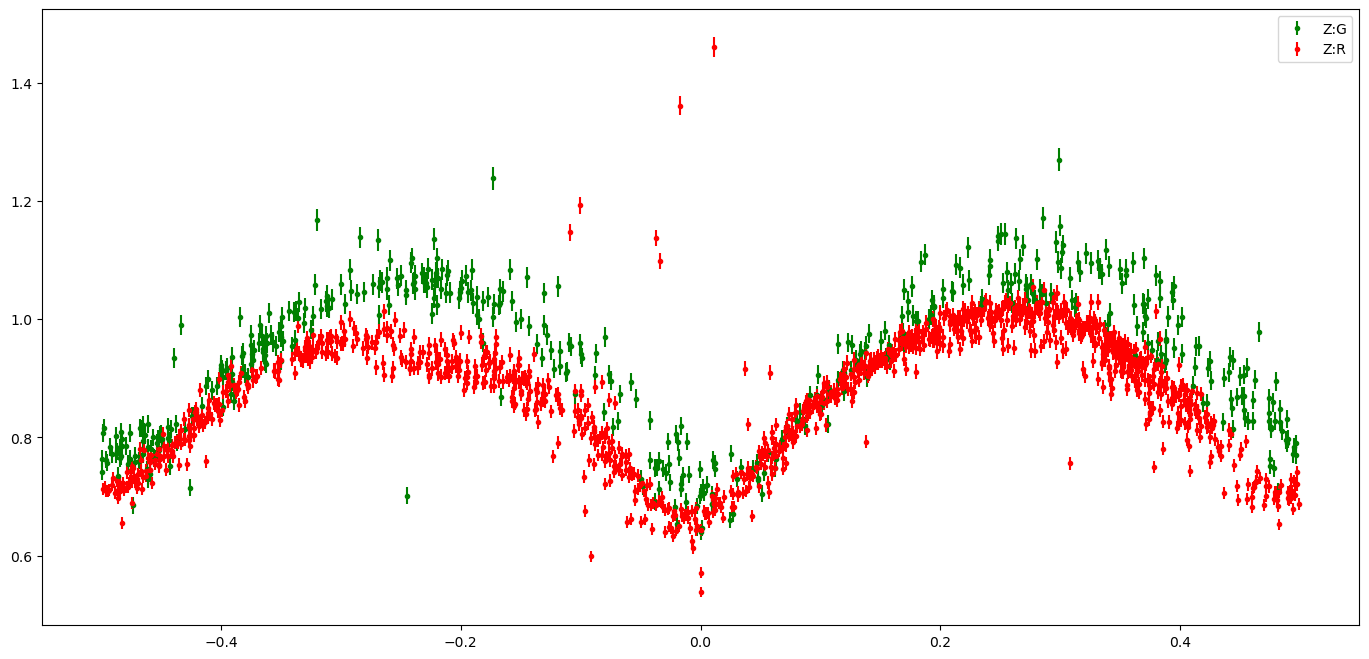

In [6]:
import numpy as np
import astropy.units as u
from astropy.timeseries import TimeSeries
from astropy.time import Time

zgTimeseries = TimeSeries(time=Time(zg['mjd'].value, format='mjd'), data={
	'mag': zg['mag'],
	'flux': zg['flux'],
	'fluxerr': zg['fluxerr']
})
zrTimeseries = TimeSeries(time=Time(zr['mjd'].value, format='mjd'), data={
	'mag': zr['mag'],
	'flux': zr['flux'],
	'fluxerr': zr['fluxerr']
})

PHOEBE_PERIOD = 0.33354138280951534 * u.day
ZTF_PERIOD = 0.333566999 * u.day # obtained from IRSA periodogram

zgFoldedTs = zgTimeseries.fold(period=ZTF_PERIOD, epoch_time=zgTimeseries.time[np.argmin(zg['flux'])], normalize_phase=True)
zrFoldedTs = zrTimeseries.fold(period=ZTF_PERIOD, epoch_time=zrTimeseries.time[np.argmin(zr['flux'])], normalize_phase=True)

plt.figure(figsize=(17, 8))
plt.errorbar(zgFoldedTs.time.value, zgFoldedTs['flux'], zgFoldedTs['fluxerr'], linestyle='none', marker='.', color='green', label='Z:G')
plt.errorbar(zrFoldedTs.time.value, zrFoldedTs['flux'], zrFoldedTs['fluxerr'], linestyle='none', marker='.', color='red', label='Z:R')
plt.legend()

In [10]:
zg.write(os.path.join(ZTF_DATA_DIR, "zg-flux.ecsv"))
zr.write(os.path.join(ZTF_DATA_DIR, "zr-flux.ecsv"))